In [2]:
import pyopenms as oms
from pyteomics import mgf
import os
import pandas as pd
from pyteomics.mass import calculate_mass
from psm_utils import PSM, PSMList

from spectrum_utils.proforma import Proteoform, Modification
from spectrum_utils.fragment_annotation import get_theoretical_fragments
from psm_utils import Peptidoform
from spectrum_utils import proforma

from denovo_utils.analysis import calculate_hyperscore
from denovo_utils.parsers import proforma_to_theoretical_spectrum
from denovo_utils.parsers.converters import SpectralisParser, DenovoEngineConverter
from ms2rescore.feature_generators import BasicFeatureGenerator, MS2PIPFeatureGenerator, DeepLCFeatureGenerator

import deeplc
from deeplc.plot import scatter
from ms2rescore.report.charts import (
    calculate_feature_qvalues,
    feature_ecdf_auc_bar,
    fdr_plot,
    ms2pip_correlation,
)

from tqdm import tqdm

import spectrum_utils.plot as sup

from denovo_utils.utils.pandas import get_psm_type, get_spectralis_score
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

2024-08-13 14:54:55.843873: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-13 14:54:55.843910: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-13 14:54:55.843924: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Modification already exists in ModificationsDB. Skipping.


# How do the tools differ from each other in terms of what they predict?

This evaluation can be done on several levels.

**1. PSM**

On the PSM-level, one can look at PSM-features as defined by several modules in MS2Rescore. For instance, one tool can always predict peptides that fit better with some intensity model. Others could fit better by the number of peaks it matches or the summed matched intensity. Or even whether it looks like a human sequence. Also, check if these differences are large, and whether they can be discerned by looking at the spectrum.

**2. Peptide**

How different are these peptides? Can they be discerned? At what side (N or C-term) do errors occur? If its wrong, is it much larger or do the precursor masses very different?

### 0. Load data

In [3]:
from glob import glob

filenames = []
for p in glob("/home/samva/Doctorate/data_directory/denovo_project/mgf_filtered/*.mgf"):
    filename = os.path.basename(p).split(".")[0]
    filenames.append(filename)

In [118]:
filenames

['F01_Fraction2',
 'F01_Fraction4',
 'S14_Rep2',
 'S14_Rep1',
 'S08',
 'S03',
 'S14_Rep3',
 'F07_Fraction4',
 'S11_Fraction3',
 'S11_Fraction1',
 'S07',
 'F07_Fraction3',
 'F08_Rep2',
 'F07_Fraction2',
 'F07_Fraction1',
 'S11_Fraction2',
 'S11_Fraction4',
 'F08_Rep1',
 'F01_Fraction1',
 'F01_Fraction3',
 'F08_Rep3',
 'F06',
 'S05']

In [4]:
# filename="S03"
filenames = [
    'F01_Fraction2',
    'F01_Fraction4',
    'S14_Rep2',
    'S14_Rep1',
    #'S08',
    'S03',
    'S14_Rep3',
    'F07_Fraction4',
    'S11_Fraction3',
    'S11_Fraction1',
    'S07',
    'F07_Fraction3',
    'F08_Rep2',
    'F07_Fraction2',
    'F07_Fraction1',
    'S11_Fraction2',
    'S11_Fraction4',
    'F08_Rep1',
    'F01_Fraction1',
    'F01_Fraction3',
    'F08_Rep3',
    'F06',
    #'S05'
]

filename = "F06"
root_data="/home/samva/Doctorate/data_directory/denovo_project"
mgf_path=os.path.join(root_data, "mgf_filtered", filename + ".mgf")
results_dir=os.path.join(root_data, "denovo_results")

In [5]:
parser_spectralis = SpectralisParser(
    mgf_path=mgf_path,
    results_dir=results_dir
)

# Casanovo, instanovo, pepnet, contranovo ran together
parser_spectralis.parse(
    path_spectralis=os.path.join(
        results_dir,
        "refinement/spectralis/pt1", filename + "_annotated_rescoring.csv"
    )
)

# NovoB, Novor, PepNovo+ ran together
parser_spectralis.parse(
    path_spectralis=os.path.join(
        results_dir,
        "refinement/spectralis/pt2", filename + "_annotated_rescoring.csv"
    )
)

# Sage results ran separately
parser_spectralis.parse(
    path_spectralis=os.path.join(
        results_dir,
        "refinement/spectralis/pt3", filename + "_annotated_rescoring.csv"
    )
)

100%|██████████| 76181/76181 [00:00<00:00, 133591.27it/s]


In [6]:
psmlist = parser_spectralis.psmlist
psmlist["run"] = [filename]*len(psmlist)

In [7]:
decoy_status = psmlist["is_decoy"] 
decoy_status = np.where(decoy_status == None, False, decoy_status)
psmlist["is_decoy"] = decoy_status 

In [8]:
mgf_file = mgf.read(mgf_path)

### 1. Generate features

In [9]:
basic_fgen = BasicFeatureGenerator()
ms2pip_fgen = MS2PIPFeatureGenerator(
    model="HCD2021",
    processes=8,
    spectrum_path=mgf_path
)
deeplc_fgen = DeepLCFeatureGenerator(
    spectrum_path=mgf_path,
    processes=8
)

basic_fgen.add_features(psmlist)
print("Added basic features.")
# ms2pip_fgen.add_features(psmlist)
# print("Added MS2PIP features.")
# deeplc_fgen.add_features(psmlist)
# print("Added DeepLC features.")

for psm in tqdm(psmlist):
    hyperscore = calculate_hyperscore(
        psm=psm,
        mgf_file=mgf_file,
        engine="pyopenms"
    )
    psm["rescoring_features"].update(
        {"hyperscore": hyperscore}
    )
print("Added hyperscore.")

Added basic features.


  0%|          | 460/588585 [00:00<02:07, 4594.78it/s]

  2%|▏         | 11658/588585 [00:02<02:04, 4624.67it/s]

  4%|▍         | 26430/588585 [00:05<02:14, 4194.74it/s]

  5%|▌         | 31475/588585 [00:06<02:21, 3950.16it/s]

  9%|▊         | 50463/588585 [00:11<02:20, 3837.38it/s]

 10%|█         | 60463/588585 [00:14<02:24, 3655.17it/s]

 13%|█▎        | 78456/588585 [00:19<02:16, 3746.25it/s]

 42%|████▏     | 245680/588585 [01:00<01:07, 5101.95it/s]

<Warning: unknown N-terminal modification '43.005814' - adding it to the database> occurred 1223 times
<Warning: unknown N-terminal modification '-17.027' - adding it to the database> occurred 2 times


 42%|████▏     | 246712/588585 [01:01<01:07, 5075.96it/s]

<Warning: unknown N-terminal modification '-17.027' - adding it to the database> occurred 3 times


 42%|████▏     | 248224/588585 [01:01<01:09, 4891.06it/s]

 42%|████▏     | 249675/588585 [01:01<01:11, 4729.01it/s]

<Warning: unknown N-terminal modification '-17.027' - adding it to the database> occurred 2 times


 43%|████▎     | 252469/588585 [01:02<01:14, 4499.87it/s]

<Warning: unknown N-terminal modification '43.005814' - adding it to the database> occurred 246 times


 43%|████▎     | 254271/588585 [01:02<01:14, 4490.01it/s]

<Warning: unknown N-terminal modification '-17.027' - adding it to the database> occurred 4 times


 44%|████▎     | 256465/588585 [01:03<01:18, 4235.83it/s]

<Warning: unknown N-terminal modification '-17.027' - adding it to the database> occurred 2 times


 44%|████▍     | 258574/588585 [01:03<01:20, 4083.95it/s]

<Warning: unknown N-terminal modification '+25.980265' - adding it to the database> occurred 4 times
<Warning: unknown N-terminal modification '-17.027' - adding it to the database> occurred 2 times


 44%|████▍     | 259806/588585 [01:04<01:21, 4041.35it/s]

<Warning: unknown N-terminal modification '+25.980265' - adding it to the database> occurred 2 times


 45%|████▍     | 263495/588585 [01:04<01:22, 3935.18it/s]

<Warning: unknown N-terminal modification '-17.027' - adding it to the database> occurred 7 times


 45%|████▍     | 264674/588585 [01:05<01:24, 3834.27it/s]

<Warning: unknown N-terminal modification '-17.027' - adding it to the database> occurred 3 times


 45%|████▌     | 266681/588585 [01:05<01:21, 3960.18it/s]

<Warning: unknown N-terminal modification '-17.027' - adding it to the database> occurred 3 times


 46%|████▌     | 269432/588585 [01:06<01:23, 3832.66it/s]

<Warning: unknown N-terminal modification '+25.980265' - adding it to the database> occurred 6 times
<Warning: unknown N-terminal modification '-17.027' - adding it to the database> occurred 2 times
<Warning: unknown N-terminal modification '43.005814' - adding it to the database> occurred 720 times


 46%|████▌     | 270978/588585 [01:06<01:23, 3812.65it/s]

 46%|████▌     | 272141/588585 [01:07<01:22, 3853.91it/s]

 47%|████▋     | 276657/588585 [01:08<01:25, 3644.50it/s]

<Warning: unknown N-terminal modification '-17.027' - adding it to the database> occurred 9 times
<Warning: unknown N-terminal modification '-17.027' - adding it to the database> occurred 3 times


 47%|████▋     | 277768/588585 [01:08<01:25, 3624.56it/s]

 47%|████▋     | 278863/588585 [01:09<01:26, 3596.16it/s]

<Warning: unknown N-terminal modification '+25.980265' - adding it to the database> occurred 2 times


 48%|████▊     | 279913/588585 [01:09<01:37, 3169.17it/s]

<Warning: unknown N-terminal modification '-17.027' - adding it to the database> occurred 4 times


 48%|████▊     | 281477/588585 [01:09<01:41, 3023.79it/s]

<Warning: unknown N-terminal modification '+25.980265' - adding it to the database> occurred 2 times


 48%|████▊     | 283083/588585 [01:10<01:34, 3226.41it/s]

<Warning: unknown N-terminal modification '43.005814' - adding it to the database> occurred 645 times
<Warning: unknown N-terminal modification '-17.027' - adding it to the database> occurred 9 times


 48%|████▊     | 283810/588585 [01:10<01:28, 3433.42it/s]

<Warning: unknown N-terminal modification '43.005814' - adding it to the database> occurred 51 times
<Warning: unknown N-terminal modification '-17.027' - adding it to the database> occurred 2 times
<Warning: unknown N-terminal modification '+25.980265' - adding it to the database> occurred 2 times


100%|██████████| 588585/588585 [02:26<00:00, 4011.80it/s]

Added hyperscore.


### 2. Split in correct/incorrect

In [10]:
df = psmlist.to_dataframe()
df["spectralis_score"] = df.apply(get_spectralis_score, axis=1)
df["hyperscore"] = pd.DataFrame(df["rescoring_features"].tolist())["hyperscore"]
df["psm_type"] = df.apply(get_psm_type, axis=1)
df["proforma"] = df.peptidoform.apply(lambda x: x.proforma)

<Axes: xlabel='hyperscore', ylabel='Count'>

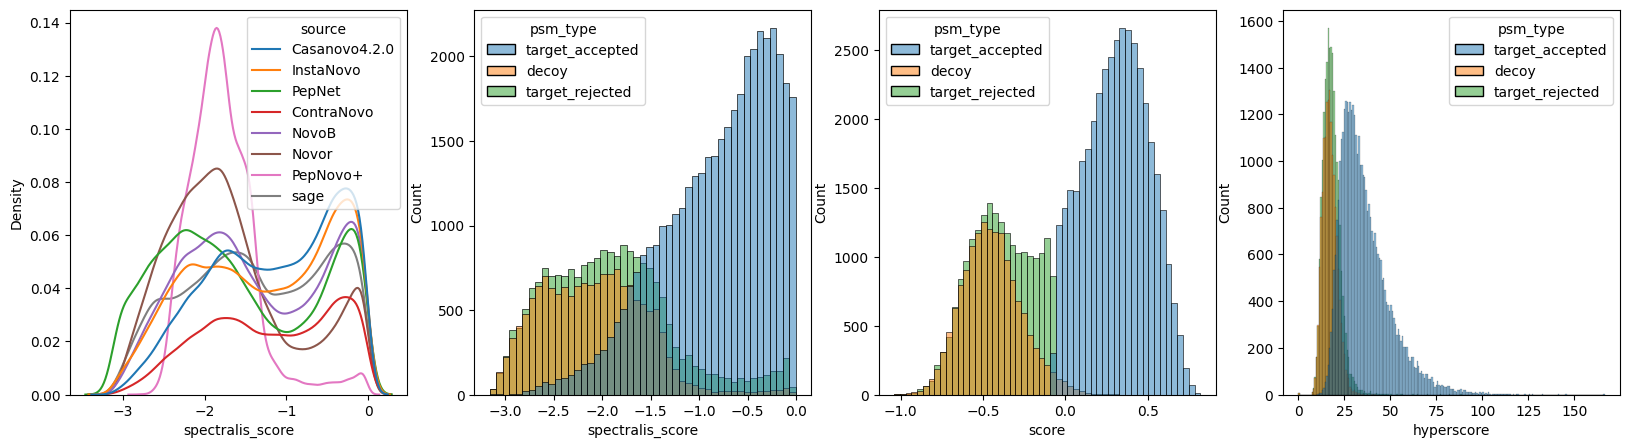

In [11]:
fig, ax  = plt.subplots(1,4, figsize=(20,5))
sns.kdeplot(
    df,
    x="spectralis_score",
    hue="source",
    ax=ax[0]
)

sns.histplot(
    df[df["source"]=="sage"],
    x="spectralis_score",
    hue="psm_type",
    ax=ax[1]
)

sns.histplot(
    df[df["source"]=="sage"],
    x="score",
    hue="psm_type",
    ax=ax[2]
)

sns.histplot(
    df[df["source"]=="sage"],
    x="hyperscore",
    hue="psm_type",
    ax=ax[3]
)

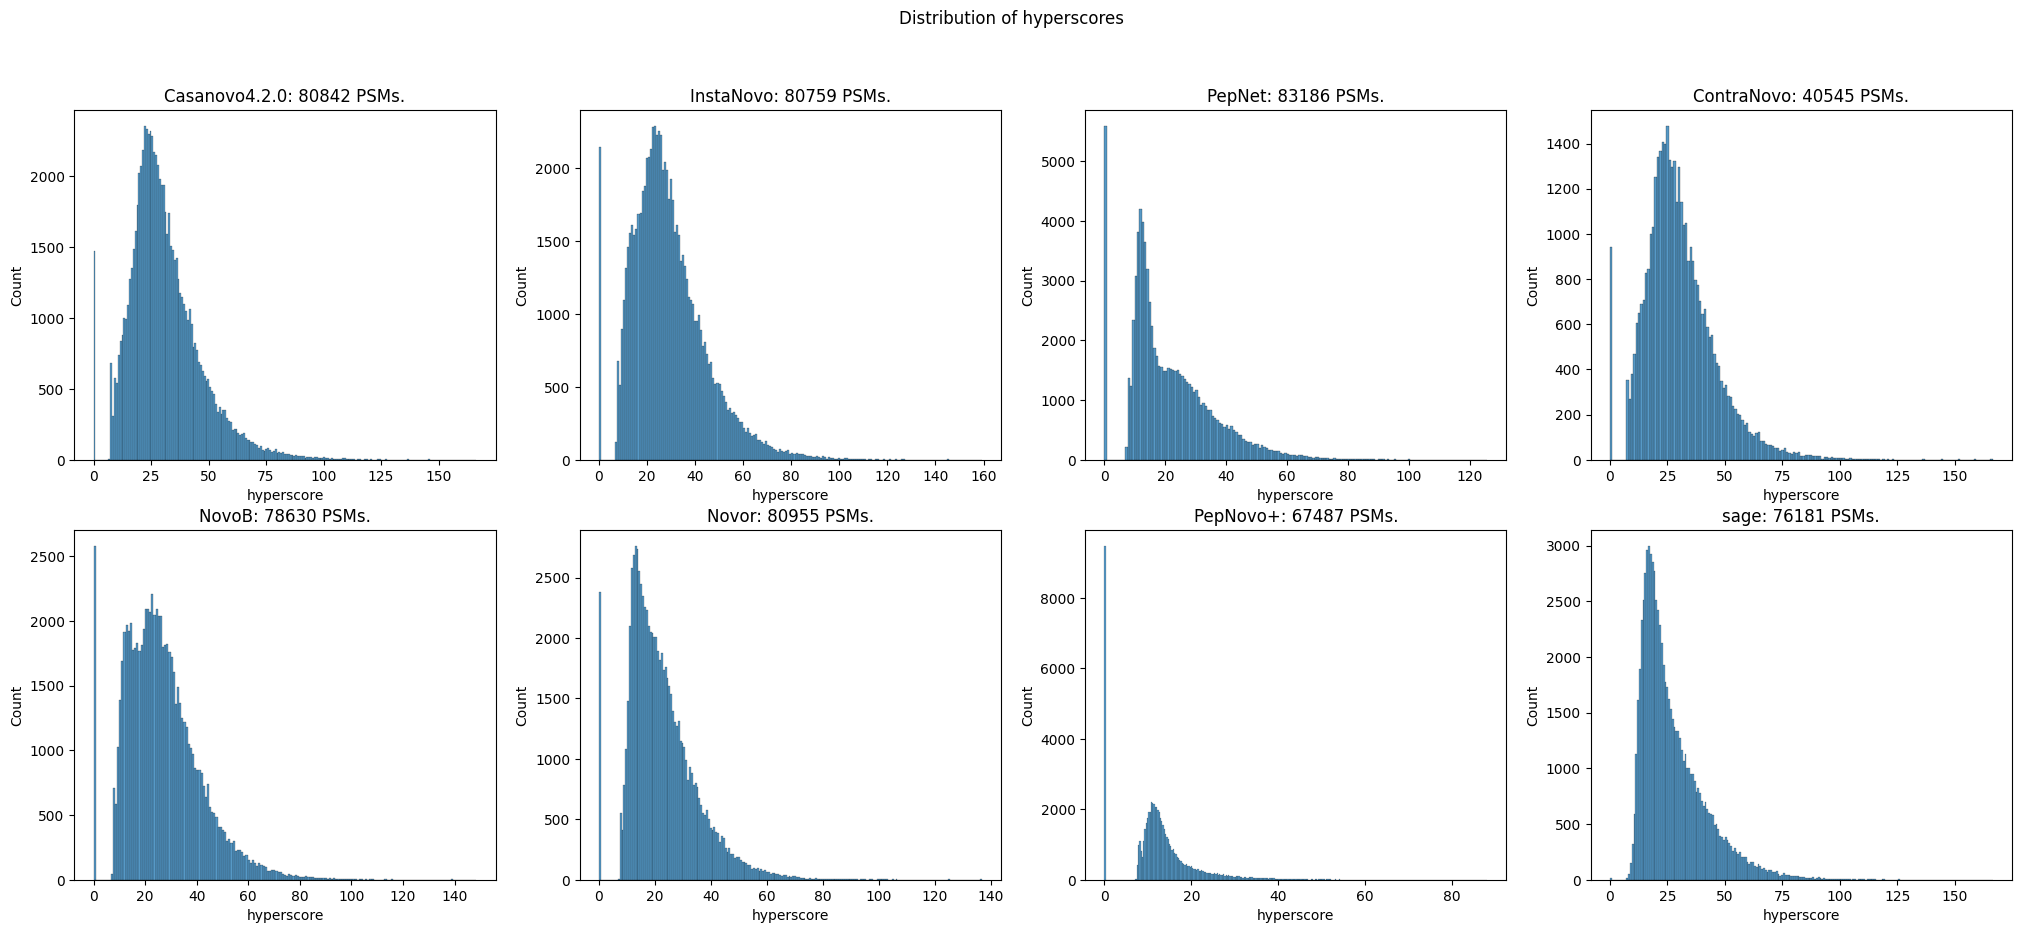

In [13]:
fig, ax = plt.subplots(2,4, figsize=(25,10))

x=0

fig.suptitle("Distribution of hyperscores")
for y, engine in enumerate(df.source.unique()):
    if y >= 4:
        x=1
        y-=4
    selection = df[
        df.source==engine
    ]
    sns.histplot(
        selection["hyperscore"],
        ax=ax[x][y]
    )
    ax[x][y].set_title(f"{engine}: {len(selection)} PSMs.")

In [19]:
df.loc[
    df["psm_type"]=="target_accepted",
    "hyperscore"
].min()

10.310323953065836

In [20]:
df_hyperscore_null = df[df.hyperscore<10.3]

In [21]:
top_null_hyperscore = df[(df.source=="Casanovo4.2.0") & (df.hyperscore==0)].sort_values("score", ascending=False).head()

In [22]:
top_null_hyperscore["score"]

67271    0.765085
773      0.735472
639      0.673959
77168    0.662634
268      0.623163
Name: score, dtype: float64

In [24]:
print([i.proforma for i in top_null_hyperscore["peptidoform"].tolist()])

print([i for i in top_null_hyperscore["spectrum_id"].tolist()])

['[UNIMOD:5]-GGNSLELWA/2', 'LKEM[UNIMOD:35]TR/2', 'VSEM[UNIMOD:35]RR/2', '[UNIMOD:1]-M[UNIMOD:35]GFLEELGRFEA/2', 'GGKSYEC[UNIMOD:4]GKSDEC[UNIMOD:4]GK/3']
['controllerType=0 controllerNumber=1 scan=73963', 'controllerType=0 controllerNumber=1 scan=1775', 'controllerType=0 controllerNumber=1 scan=1603', 'controllerType=0 controllerNumber=1 scan=85402', 'controllerType=0 controllerNumber=1 scan=1187']


In [25]:
allowed_modifications = ["[UNIMOD:4]", "[UNIMOD:35]"]

def peptidoform_has_modification(peptidoform, allowed_modificiations=["[UNIMOD:4]", "[UNIMOD:35]"]):
    peptidoform_str = peptidoform.proforma
    for allowed_modification in allowed_modificiations:
        peptidoform_str = peptidoform_str.replace(allowed_modification, "")
    
    return "[" in peptidoform_str


df["has_modification"] = df.peptidoform.apply(peptidoform_has_modification)

In [26]:
df[df.hyperscore==0].has_modification.value_counts()

has_modification
False    23977
True       601
Name: count, dtype: int64

In [27]:
top_null_hyperscore["metadata"].tolist()

[{'aa_scores': '0.42668,0.86199,0.87729,0.87523,0.87825,0.87562,0.87636,0.83487,0.55383,0.47779',
  'calc_mass_to_charge': '495.23798131688005',
  'spectra_ref': 'ms_run[1]:index=68173',
  'scans': '73963'},
 {'aa_scores': '0.82648,0.40533,0.78523,0.55694,0.86231,0.84930',
  'calc_mass_to_charge': '397.2154593168801',
  'spectra_ref': 'ms_run[1]:index=798',
  'scans': '1775'},
 {'aa_scores': '0.67667,0.39133,0.78670,0.44867,0.81832,0.76366',
  'calc_mass_to_charge': '397.20288731688',
  'spectra_ref': 'ms_run[1]:index=654',
  'scans': '1603'},
 {'aa_scores': '0.51994,0.52715,0.49912,0.72558,0.45720,0.79892,0.78741,0.81676,0.82426,0.81869,0.77318,0.33601,0.56583',
  'calc_mass_to_charge': '728.8424853168801',
  'spectra_ref': 'ms_run[1]:index=78956',
  'scans': '85402'},
 {'aa_scores': '0.50169,0.51363,0.56375,0.67496,0.45427,0.77055,0.46442,0.45648,0.64710,0.54694,0.46582,0.78367,0.79022,0.74011,0.79068',
  'calc_mass_to_charge': '554.5679837002134',
  'spectra_ref': 'ms_run[1]:index=2

In [28]:
from denovo_utils.analysis.visualization import plot_spectrum

In [46]:
df.loc[
    df.spectrum_id=="controllerType=0 controllerNumber=1 scan=1187",
    ["proforma", "source", "spectralis_score", "hyperscore", "score", "psm_type"]
]

,proforma,source,spectralis_score,hyperscore,score,psm_type
268,GGKSYEC[UNIMOD:4]GKSDEC[UNIMOD:4]GK/3,Casanovo4.2.0,-2.441068,0.000000,0.623163,target_rejected
81095,GGKPEC[UNIMOD:4]HQC[UNIMOD:4]NEC[UNIMOD:4]GK/3,InstaNovo,-2.390711,0.000000,-5.502764,target_rejected
161876,GKPPAAHDDHSSSRR/3,PepNet,-2.445470,8.680242,0.000000,target_rejected
285573,KQEDDDHQASAMMR/3,NovoB,-2.244951,9.430987,0.000169,target_rejected
364222,QGEM[UNIMOD:35]DDYRDFLEK/3,Novor,-2.315292,0.000000,7.700000,target_rejected


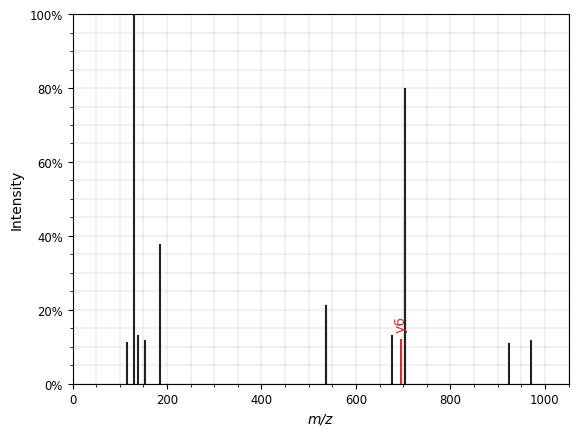

In [47]:
plot_spectrum(
    mgf_path=mgf_path,
    spectrum_id='controllerType=0 controllerNumber=1 scan=1187',
    peptide='GGKSYEC[UNIMOD:4]GKSDEC[UNIMOD:4]GK/3',
    fragment_tol_mass=.02,
    fragment_tol_mode="Da"
)

<Axes: xlabel='score', ylabel='Count'>

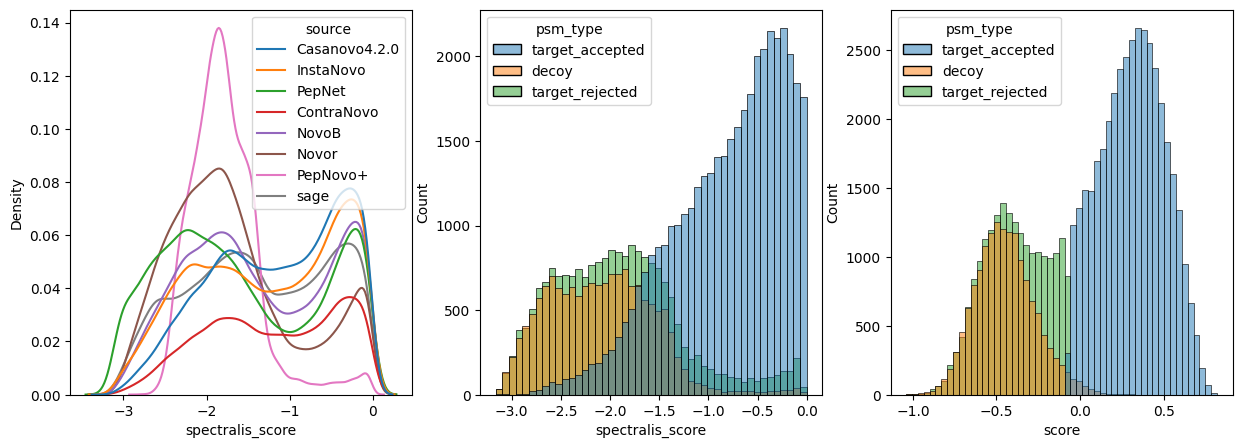

In [48]:
fig, ax  = plt.subplots(1,3, figsize=(15,5))
sns.kdeplot(
    df,
    x="spectralis_score",
    hue="source",
    ax=ax[0]
)

sns.histplot(
    df[df["source"]=="sage"],
    x="spectralis_score",
    hue="psm_type",
    ax=ax[1]
)

sns.histplot(
    df[df["source"]=="sage"],
    x="score",
    hue="psm_type",
    ax=ax[2]
)

In [49]:
metrics = "/home/samva/Doctorate/data_directory/denovo_project/denovo_results/psmlists/metrics"

from glob import glob
import json

accuracy_list = []
gmm_list = []
for p in glob(os.path.join(metrics, "*.json")):

    with open(p, "r") as f:
        metric = json.load(f)

        metric_df = pd.DataFrame(metric)

        if "gmm" in p:
            metric_df = metric_df.T
            metric_df["filename"]= "_".join(p.split("/")[-1].split("_")[:2])
            gmm_list.append(metric_df)
        else:
            metric_df["filename"]= "_".join(p.split("/")[-1].split("_")[:2])
            accuracy_list.append(metric_df)


accuracy_df = pd.concat(accuracy_list)
gmm_df = pd.concat(gmm_list)

dfs_accuracy={}
for i, df_ in accuracy_df.reset_index().groupby("index"):
    dfs_accuracy[i]=df_

accuracy_by_engine = []
for engine, df_ in dfs_accuracy.items(): 
    filenames = df_["filename"].tolist()
    accuracy_engine = pd.DataFrame(df_["accuracy"].to_list())
    accuracy_engine["engine"] = engine
    accuracy_engine["filename"] = filenames
    accuracy_by_engine.append(accuracy_engine)
accuracy_by_engine_df = pd.concat(accuracy_by_engine)

dfs_gmm={}
for i, df_ in gmm_df.reset_index().groupby("index"):
    dfs_gmm[i]=df_

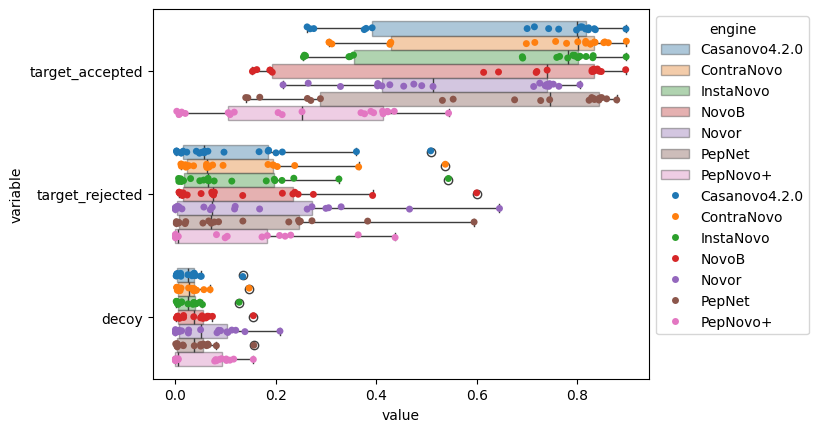

In [50]:
from matplotlib.legend_handler import HandlerTuple


ax = sns.boxplot(data=accuracy_by_engine_df.loc[:,accuracy_by_engine_df.columns!="filename"].melt(id_vars="engine"), x="value", y="variable",
                 hue="engine", boxprops={'alpha': 0.4})
sns.stripplot(data=accuracy_by_engine_df.loc[:,accuracy_by_engine_df.columns!="filename"].melt(id_vars="engine"), x="value", y="variable",
              hue="engine", dodge=True, ax=ax)
handles, labels = ax.get_legend_handles_labels()

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [51]:
dfs_gmm["Casanovo4.2.0"][["filename", "spectralis_cutoff"]]

,filename,spectralis_cutoff
0,S11_Fraction3,-0.835647
7,F01_Fraction4,-1.498252
14,F01_Fraction1,-1.505127
21,F07_Fraction3,-0.926659
28,S11_Fraction1,-0.854978
35,S11_Fraction4,-0.946193
42,F08_Rep3,-1.97544
49,S14_Rep3,-1.861264
56,S14_Rep2,-1.880095
63,S14_Rep1,-1.874671


<Axes: xlabel='spectralis_cutoff', ylabel='target_accepted'>

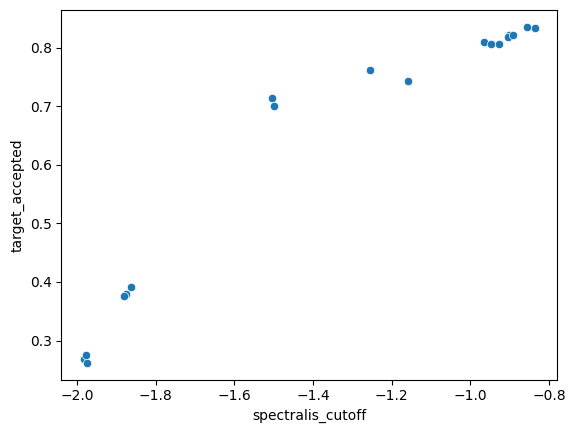

In [129]:
sns.scatterplot(
    x=dfs_gmm["Casanovo4.2.0"].set_index("filename")["spectralis_cutoff"],
    y=accuracy_by_engine_df[accuracy_by_engine_df["engine"]=="Casanovo4.2.0"].set_index("filename")["target_accepted"]
)

---

# Investigate Hyperscore == 0 with good de novo scores

In [52]:
df_hyperscore_null["source"].value_counts()

source
PepNovo+         20662
PepNet           12009
Novor             5694
NovoB             5457
InstaNovo         4547
Casanovo4.2.0     3409
ContraNovo        1983
sage               557
Name: count, dtype: int64

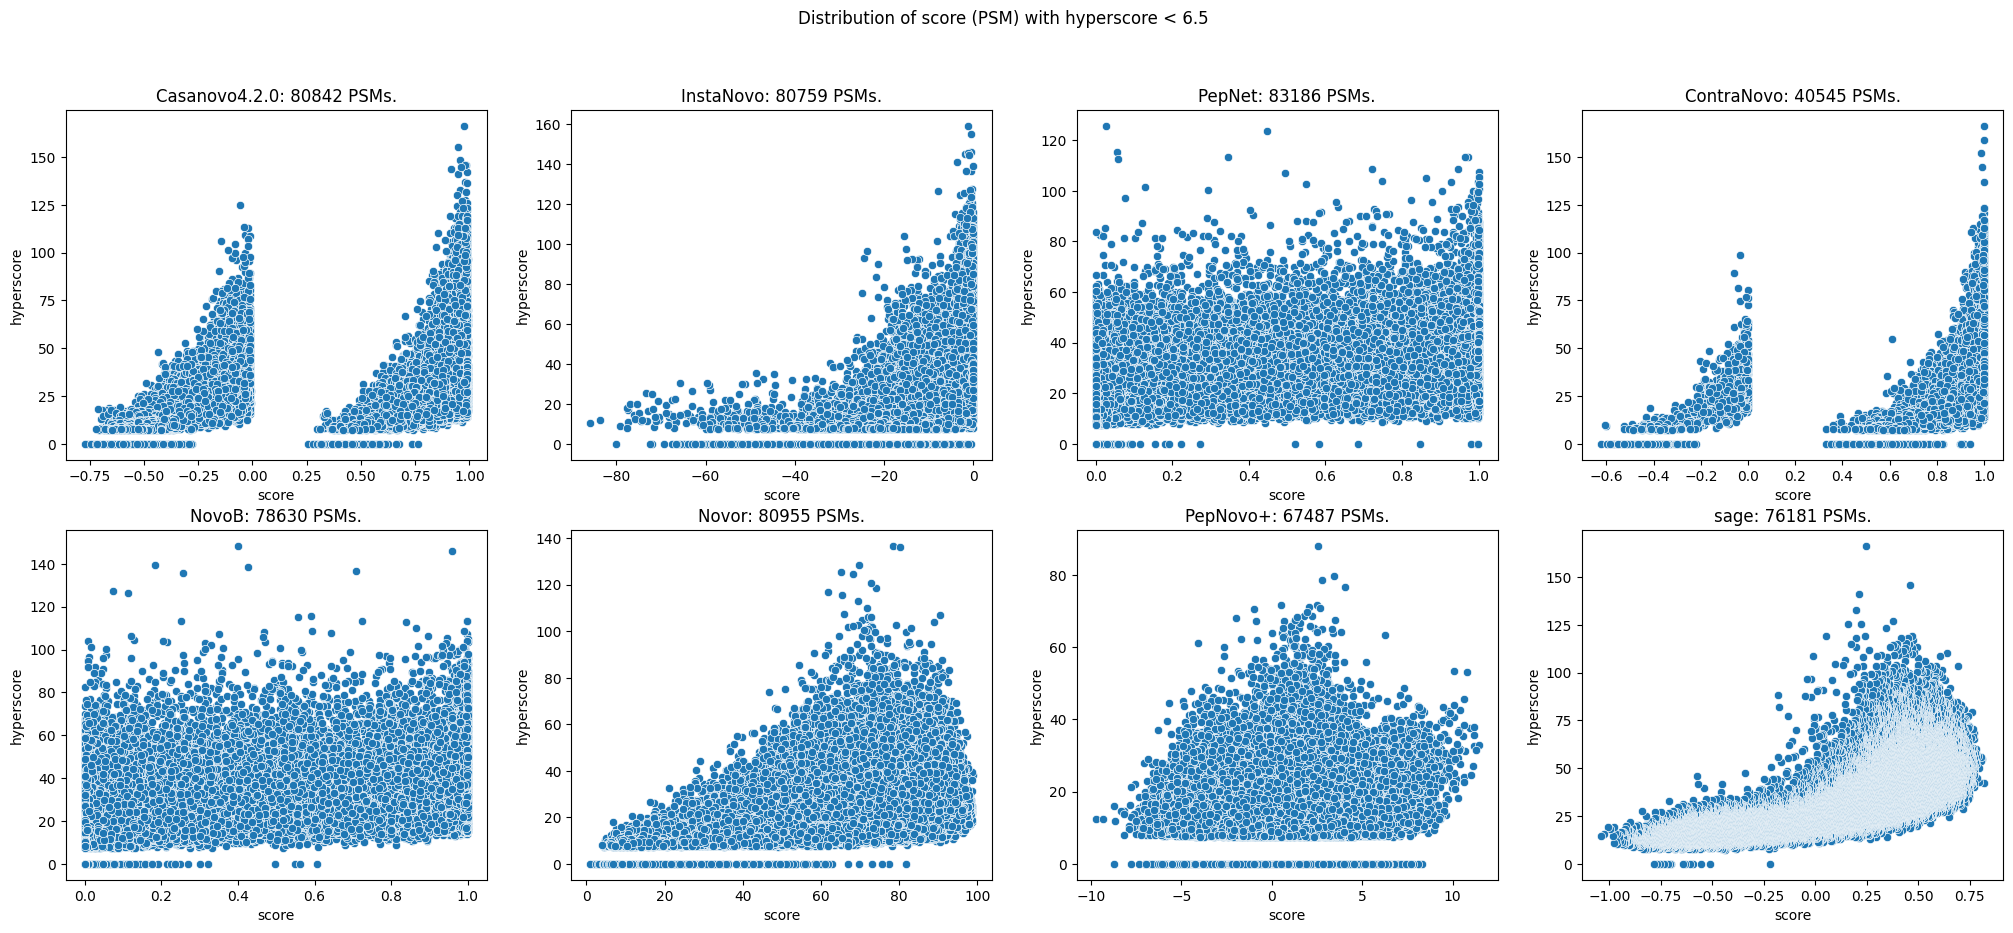

In [53]:
fig, ax = plt.subplots(2,4, figsize=(25,10))

x=0

fig.suptitle("Distribution of score (PSM) with hyperscore < 6.5")
for y, engine in enumerate(df.source.unique()):
    if y >= 4:
        x=1
        y-=4
    selection = df[
        df.source==engine
    ]
    sns.scatterplot(
        selection,
        x="score",
        y="hyperscore",
        ax=ax[x][y]
    )
    ax[x][y].set_title(f"{engine}: {len(selection)} PSMs.")

In [139]:
df_hyperscore_null.loc[
    df_hyperscore_null.source=="sage",
    ["proforma", "spectrum_id", "score", "hyperscore", "spectralis_score", "qvalue", "is_decoy"]
].sort_values('score', ascending=False).head(10).to_dict("records")

[{'proforma': 'ELC[UNIMOD:4]GFK/1',
  'spectrum_id': 'Cmpd 6860, +MS2(754.3613), 39.5eV, 22.63min #8213',
  'score': -0.051922467,
  'hyperscore': 6.202535517187923,
  'spectralis_score': -1.4168502314133398,
  'qvalue': 0.014144441,
  'is_decoy': False},
 {'proforma': 'VSEIADSK/2',
  'spectrum_id': 'Cmpd 1582, +MS2(425.2229), 24.0eV, 14.22min #2780',
  'score': -0.11343856,
  'hyperscore': 6.495265555937008,
  'spectralis_score': -1.463059532584163,
  'qvalue': 0.027273746,
  'is_decoy': False},
 {'proforma': 'KM[UNIMOD:35]M[UNIMOD:35]AQMKNMDTK/2',
  'spectrum_id': 'Cmpd 1328, +MS2(744.8415), 38.4eV, 13.71min #2516',
  'score': -0.16657428,
  'hyperscore': 6.413458957167357,
  'spectralis_score': -2.3511549489531696,
  'qvalue': 0.047780484,
  'is_decoy': False},
 {'proforma': 'GLFFTSIAM[UNIMOD:35]AM[UNIMOD:35]R/3',
  'spectrum_id': 'Cmpd 29998, +MS2(459.8963), 24.2eV, 59.82min #32036',
  'score': -0.17351112,
  'hyperscore': 6.218600119691729,
  'spectralis_score': -2.147851508316221

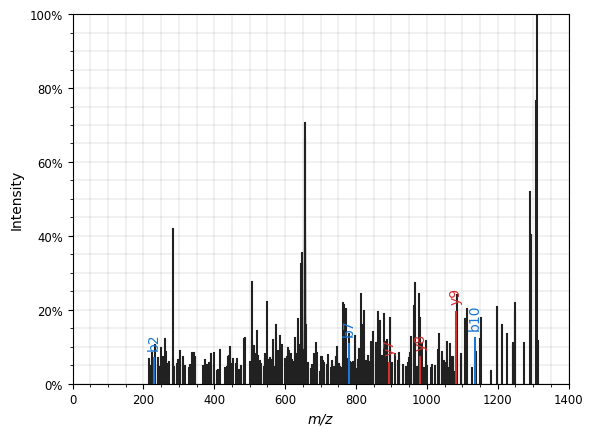

In [138]:
plot_spectrum(
    mgf_path=mgf_path,
    spectrum_id='Cmpd 18620, +MS2(655.8224), 27.0eV, 41.27min #20315',
    peptide='DLTSVTYQDIR/2',
    fragment_tol_mass=.02,
    fragment_tol_mode="Da"
)

In [55]:
df_hyperscore_null.loc[
        (df_hyperscore_null["source"]=="NovoB") & (df_hyperscore_null["score"]>.8),:].shape

(1, 22)

<Axes: xlabel='spectralis_score', ylabel='Count'>

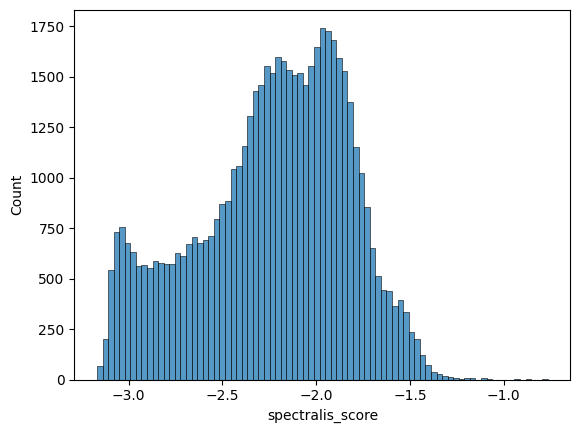

In [54]:
sns.histplot(df_hyperscore_null["spectralis_score"])

In [149]:
df.loc[
    (df.hyperscore>60) &
    (df.source=="NovoB") &
    (df.score < .2),
    ["proforma", "spectrum_id", "score", "hyperscore", "spectralis_score"]
].to_dict("records")

[{'proforma': 'SYSC[UNIMOD:4]QVTHEGSTVEK/2',
  'spectrum_id': 'Cmpd 2158, +MS2(856.3834), 47.8eV, 15.32min #3377',
  'score': 0.118521,
  'hyperscore': 63.80127994390463,
  'spectralis_score': -0.9838537789525964},
 {'proforma': 'GALAHVNLGTLGHVDHGK/3',
  'spectrum_id': 'Cmpd 2801, +MS2(599.3244), 27.0eV, 16.36min #4039',
  'score': 0.074683,
  'hyperscore': 64.14576298658885,
  'spectralis_score': -1.907575155621717},
 {'proforma': 'VTGC[UNIMOD:4]NTEHHC[UNIMOD:4]LGGGGFFPQGK/3',
  'spectrum_id': 'Cmpd 8015, +MS2(754.0064), 34.1eV, 24.47min #9402',
  'score': 0.131563,
  'hyperscore': 73.20979768531296,
  'spectralis_score': -1.811800419032925},
 {'proforma': 'LADHNLEVLNADEQFLNAAK/2',
  'spectrum_id': 'Cmpd 24985, +MS2(1113.0636), 55.0eV, 51.55min #26870',
  'score': 0.023745,
  'hyperscore': 62.4167713109035,
  'spectralis_score': -1.6551999200603582},
 {'proforma': 'LETGLLVHGDPVELVGLEEK/3',
  'spectrum_id': 'Cmpd 34774, +MS2(716.3912), 29.0eV, 68.31min #36970',
  'score': 0.05236,
  'h

In [152]:
df.loc[
    (df.spectrum_id=='Cmpd 2158, +MS2(856.3834), 47.8eV, 15.32min #3377'),
    ["proforma", "spectrum_id", "score", "hyperscore", "spectralis_score", "source"]
]

,proforma,spectrum_id,score,hyperscore,spectralis_score,source
1875,SYSC[UNIMOD:4]QVTHEGSTVEK/2,"Cmpd 2158, +MS2(856.3834), 47.8eV, 15.32min #3377",0.989436,63.801280,-0.983854,Casanovo4.2.0
53712,SYSC[UNIMOD:4]QVTHEGSTVEK/2,"Cmpd 2158, +MS2(856.3834), 47.8eV, 15.32min #3377",-0.033581,63.801280,-0.983854,InstaNovo
104560,SYSC[UNIMOD:4]AVTHEGSTVEK/2,"Cmpd 2158, +MS2(856.3834), 47.8eV, 15.32min #3377",0.999900,28.715702,-1.849382,PepNet
192643,SYSC[UNIMOD:4]QVTHEGSTVEK/2,"Cmpd 2158, +MS2(856.3834), 47.8eV, 15.32min #3377",0.118521,63.801280,-0.983854,NovoB
238465,SYSC[UNIMOD:4]QVTHEGSTVTR/2,"Cmpd 2158, +MS2(856.3834), 47.8eV, 15.32min #3377",83.300000,47.520606,-1.329564,Novor
240599,HLSC[UNIMOD:4]QVTHEGSTVE/2,"Cmpd 2158, +MS2(856.3834), 47.8eV, 15.32min #3377",2.422000,12.590682,-2.413065,PepNovo+
264854,VGTYFPHC[UNIMOD:4]QSC[UNIMOD:4]VEK/2,"Cmpd 2158, +MS2(856.3834), 47.8eV, 15.32min #3377",-0.255356,21.870921,-2.001349,sage


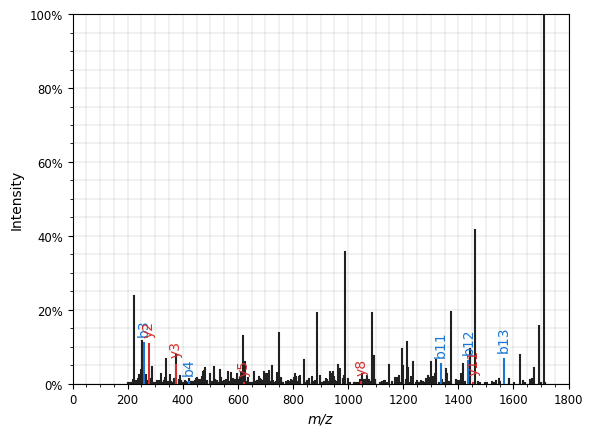

In [153]:
plot_spectrum(
    mgf_path=mgf_path,
    spectrum_id='Cmpd 2158, +MS2(856.3834), 47.8eV, 15.32min #3377',
    peptide='VGTYFPHC[UNIMOD:4]QSC[UNIMOD:4]VEK/2',
    fragment_tol_mass=.02,
    fragment_tol_mode="Da"
)

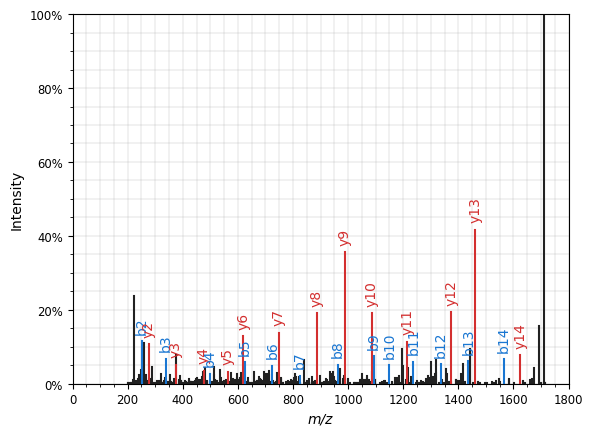

In [150]:
plot_spectrum(
    mgf_path=mgf_path,
    spectrum_id='Cmpd 2158, +MS2(856.3834), 47.8eV, 15.32min #3377',
    peptide='SYSC[UNIMOD:4]QVTHEGSTVEK/2',
    fragment_tol_mass=.02,
    fragment_tol_mode="Da"
)

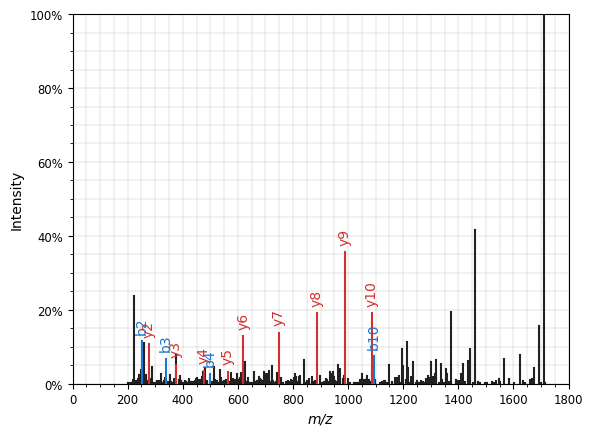

In [154]:
plot_spectrum(
    mgf_path=mgf_path,
    spectrum_id='Cmpd 2158, +MS2(856.3834), 47.8eV, 15.32min #3377',
    peptide='SYSC[UNIMOD:4]AVTHEGSTVEK/2',
    fragment_tol_mass=.02,
    fragment_tol_mode="Da"
)

In [14]:
spectrum_hyperscore = df.loc[
    (df["psm_type"]=="target_accepted"),
    ["spectrum_id", "hyperscore"]
].set_index("spectrum_id").to_dict()["hyperscore"]

spectrum_peptide = df.loc[
    (df["psm_type"]=="target_accepted"),
    ["spectrum_id", "proforma"]
].set_index("spectrum_id").to_dict()["proforma"]

In [15]:
def hyperscore_difference(row, reference):
    try:
        reference_hyperscore = reference[row["spectrum_id"]]
        return float(row["hyperscore"])-float(reference_hyperscore)
    except:
        return None
    
def hyperscore_diff_discretize(row):
    h_diff = row["hyperscore_diff"]
    if isinstance(h_diff, float):
        if h_diff==0.0:
            return "Equal"
        elif h_diff > 0:
            return "Better"
        elif h_diff < 0:
            return "Worse"
        else:
            return None
    return None

In [16]:
df["hyperscore_diff"] = df.apply(lambda x: hyperscore_difference(x, reference=spectrum_hyperscore), axis=1)
df["hyperscore_better"] = df.apply(lambda x: hyperscore_diff_discretize(x), axis=1)

In [17]:
df.groupby("source").hyperscore_better.value_counts()

source         hyperscore_better
Casanovo4.2.0  Equal                27029
               Worse                 9135
               Better                4050
ContraNovo     Equal                13262
               Worse                 5193
               Better                1840
InstaNovo      Equal                26395
               Worse                10246
               Better                3598
NovoB          Equal                20435
               Worse                16697
               Better                2668
Novor          Worse                29304
               Equal                 8671
               Better                2249
PepNet         Worse                23060
               Equal                16000
               Better                1210
PepNovo+       Worse                32456
               Equal                 1104
               Better                 268
sage           Equal                40270
Name: count, dtype: int64

<Axes: xlabel='score', ylabel='hyperscore_diff'>

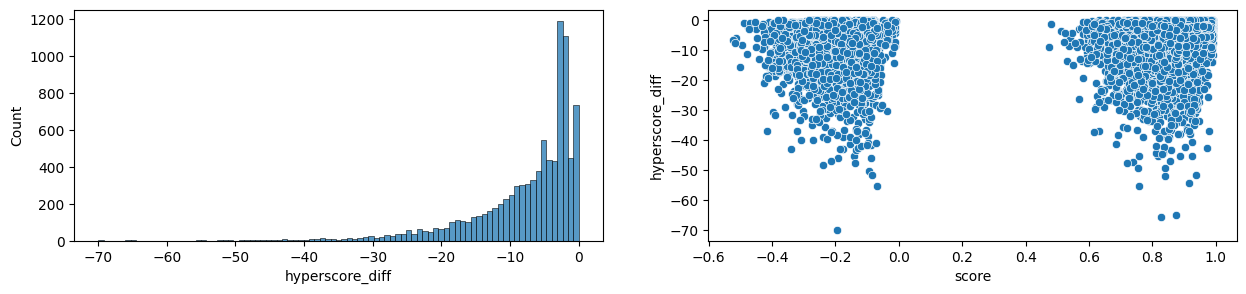

In [60]:
fig, ax = plt.subplots(1,2, figsize=(15,3))

sns.histplot(
    df.loc[
        (df.source=="Casanovo4.2.0") & 
        (df.hyperscore_better=="Worse"),
        "hyperscore_diff"
    ],
    ax=ax[0]
)

sns.scatterplot(
    df.loc[
        (df.source=="Casanovo4.2.0") & 
        (df.hyperscore_better=="Worse"),
        ["score", "hyperscore_diff"]
    ],
    x="score",
    y="hyperscore_diff",
    ax=ax[1]
)

<Axes: xlabel='score', ylabel='hyperscore_diff'>

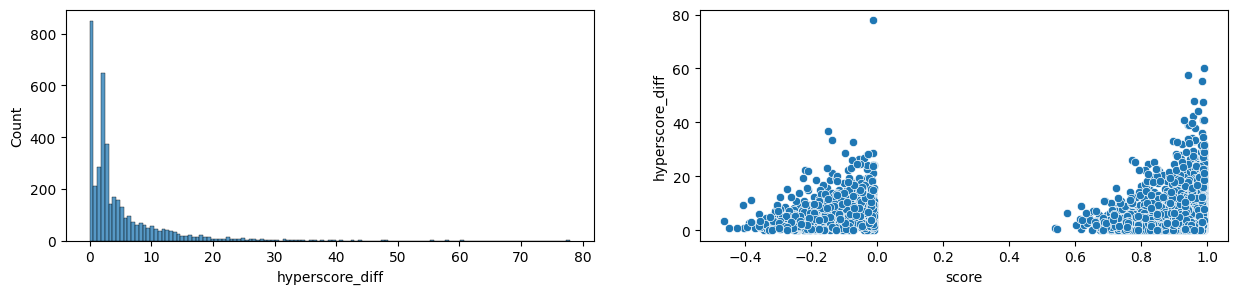

In [61]:
fig, ax = plt.subplots(1,2, figsize=(15,3))

sns.histplot(
    df.loc[
        (df.source=="Casanovo4.2.0") & 
        (df.hyperscore_better=="Better"),
        "hyperscore_diff"
    ],
    ax=ax[0]
)

sns.scatterplot(
    df.loc[
        (df.source=="Casanovo4.2.0") & 
        (df.hyperscore_better=="Better"),
        ["score", "hyperscore_diff"]
    ],
    x="score",
    y="hyperscore_diff",
    ax=ax[1]
)

<Axes: xlabel='score', ylabel='hyperscore_diff'>

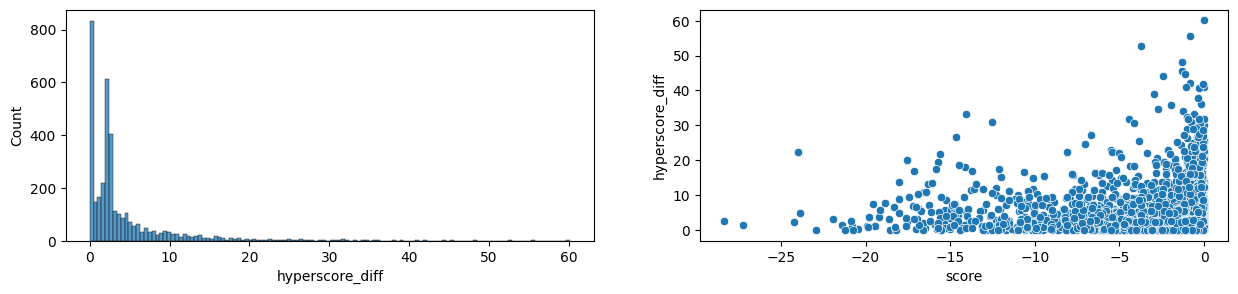

In [62]:
fig, ax = plt.subplots(1,2, figsize=(15,3))

sns.histplot(
    df.loc[
        (df.source=="InstaNovo") & 
        (df.hyperscore_better=="Better"),
        "hyperscore_diff"
    ],
    ax=ax[0]
)

sns.scatterplot(
    df.loc[
        (df.source=="InstaNovo") & 
        (df.hyperscore_better=="Better"),
        ["score", "hyperscore_diff"]
    ],
    x="score",
    y="hyperscore_diff",
    ax=ax[1]
)

---

In [18]:
df.columns

Index(['peptidoform', 'spectrum_id', 'run', 'collection', 'spectrum',
       'is_decoy', 'score', 'qvalue', 'pep', 'precursor_mz', 'retention_time',
       'ion_mobility', 'protein_list', 'rank', 'source', 'provenance_data',
       'metadata', 'rescoring_features', 'spectralis_score', 'hyperscore',
       'psm_type', 'proforma', 'hyperscore_diff', 'hyperscore_better'],
      dtype='object')

In [33]:
from denovo_utils.utils.pandas import evaluate_prediction
df["peptide"] = df["peptidoform"].apply(lambda x: x.sequence.replace("I", "L"))

In [34]:
df_filtered = df[df.spectrum_id.isin(df[(df.source=="sage") & (df.psm_type=="target_accepted")]["spectrum_id"].tolist())]

In [65]:
from typing import Optional
def evaluate_prediction(row: pd.Series, ground_truth: dict) -> Optional[bool]:
    """
    Evaluate the truthness of a de novo prediction by comparing it with ground truth.

    Parameter
    ---------
    row: pd.Series
        The row containing the spectrum_id and peptide prediction in
        columns 'spectrum_id' and 'peptide' respectively.
    ground_truth: pd.DataFrame
        A dataframe with columns 'spectrum_id' and 'peptide' which are
        used to extract the spectrum_id of the PSM and the peptide sequence.

    Return
    ------
    Optional[bool]
        True or False dependent on correctness, None if the spectrum was not given
        a PSM with the ground truth search.
    """
    try:
        ground_truth_peptidoform = ground_truth[row["spectrum_id"]]
        return ground_truth_peptidoform == row["peptide"]

    except Exception:
        return None


In [66]:
id_peptide = df_filtered.loc[df_filtered.source=="sage", ["spectrum_id", "peptide"]].set_index("spectrum_id").to_dict()["peptide"]

In [69]:
df_filtered["match_db"] = df_filtered.progress_apply(
        lambda x: evaluate_prediction(
            row=x, ground_truth=id_peptide),
        axis=1
    )

100%|██████████| 295140/295140 [00:01<00:00, 273853.45it/s]


In [71]:
df_filtered[
    (df_filtered["match_db"]) &
    (df_filtered["hyperscore_better"]=="Equal")
].head()

,peptidoform,spectrum_id,run,collection,spectrum,is_decoy,score,qvalue,pep,precursor_mz,...,rescoring_features,spectralis_score,hyperscore,psm_type,proforma,has_modification,hyperscore_diff,hyperscore_better,peptide,match_db
184,"((V, None), (N, None), (P, None), (H, None), (...",controllerType=0 controllerNumber=1 scan=1091,F06,None,None,False,0.959474,NaN,None,413.704163,...,"{'spectralis_score': -1.5262620030197287, 'cha...",-1.526262,15.783659,target_rejected,VNPHGM[UNIMOD:35]R/2,False,0.0,Equal,VNPHGMR,True
188,"((M, [UNIMOD:35]), (C, [UNIMOD:4]), (A, None),...",controllerType=0 controllerNumber=1 scan=1095,F06,None,None,False,0.986897,NaN,None,486.538452,...,"{'spectralis_score': -1.2340970616619666, 'cha...",-1.234097,44.057496,target_rejected,M[UNIMOD:35]C[UNIMOD:4]AGGTAAHSDHAR/3,False,0.0,Equal,MCAGGTAAHSDHAR,True
237,"((K, None), (E, None), (A, None), (K, None), (...",controllerType=0 controllerNumber=1 scan=1151,F06,None,None,False,0.988623,NaN,None,419.250427,...,"{'spectralis_score': -0.5182343732666627, 'cha...",-0.518234,28.749360,target_rejected,KEAKPAVEQKK/3,False,0.0,Equal,KEAKPAVEQKK,True
324,"((K, None), (E, None), (A, None), (K, None), (...",controllerType=0 controllerNumber=1 scan=1251,F06,None,None,False,0.961022,NaN,None,628.863770,...,"{'spectralis_score': -0.9612491787776882, 'cha...",-0.961249,31.310355,target_rejected,KEAKPAVEEKK/2,False,0.0,Equal,KEAKPAVEEKK,True
337,"((K, None), (E, None), (A, None), (K, None), (...",controllerType=0 controllerNumber=1 scan=1265,F06,None,None,False,0.985464,NaN,None,419.578247,...,"{'spectralis_score': -0.2848232911225433, 'cha...",-0.284823,42.599652,target_rejected,KEAKPAVEEKK/3,False,0.0,Equal,KEAKPAVEEKK,True


In [77]:
df_filtered.loc[
    df_filtered["spectrum_id"]=="controllerType=0 controllerNumber=1 scan=1091",
    ["proforma", "peptide", "source", "match_db", "hyperscore_diff"]
]

,proforma,peptide,source,match_db,hyperscore_diff
184,VNPHGM[UNIMOD:35]R/2,VNPHGMR,Casanovo4.2.0,True,0.000000
81012,VNPHGM[UNIMOD:35]R/2,VNPHGMR,InstaNovo,True,0.000000
161789,VNPHFGR/2,VNPHFGR,PepNet,False,-6.521786
244879,VNPHGM[UNIMOD:35]R/2,VNPHGMR,ContraNovo,True,0.000000
285500,VNPHGM[UNIMOD:35]R/2,VNPHGMR,NovoB,True,0.000000
364140,NVPHGM[UNIMOD:35]R/2,NVPHGMR,Novor,False,0.000000
551128,VNPHGM[UNIMOD:35]R/2,VNPHGMR,sage,True,0.000000


In [67]:
psms_matching = df_filtered[
    df_filtered.progress_apply(
        lambda x: evaluate_prediction(
            row=x, ground_truth=id_peptide),
        axis=1
    )
]
psms_not_matching = df_filtered[
    ~df_filtered.progress_apply(
        lambda x: evaluate_prediction(
            row=x, ground_truth=id_peptide
        ),
        axis=1
    )
]

100%|██████████| 295140/295140 [00:01<00:00, 277645.37it/s]


In [68]:
psms_matching.source.value_counts()

source
sage             40270
Casanovo4.2.0    10528
InstaNovo        10272
NovoB             8388
PepNet            6668
ContraNovo        5480
Novor             3347
PepNovo+           511
Name: count, dtype: int64

In [86]:
psms_matching.groupby("source").hyperscore_better.value_counts().sort_index()

source         hyperscore_better
Casanovo4.2.0  Better                  10
               Equal                10517
               Worse                    1
ContraNovo     Better                  10
               Equal                 5240
               Worse                  230
InstaNovo      Equal                10270
               Worse                    2
NovoB          Equal                 8386
               Worse                    2
Novor          Equal                 3347
PepNet         Equal                 6667
               Worse                    1
PepNovo+       Equal                  511
sage           Equal                40270
Name: count, dtype: int64

Some of the PSMs with the same base sequence (stripped from modifications) have either the same modification on a different location or assign modifications where there should(n't) be one. The hyperscore nicely shows whether the modification actually improves upon the matching of peaks

In [117]:
psms_matching[
    (psms_matching["hyperscore_better"]=="Better") &
    (psms_matching["source"]=="Casanovo4.2.0")
].head(3)

,peptidoform,spectrum_id,run,collection,spectrum,is_decoy,score,qvalue,pep,precursor_mz,...,metadata,rescoring_features,spectralis_score,hyperscore,psm_type,proforma,has_modification,hyperscore_diff,hyperscore_better,peptide
12989,"((V, None), (A, None), (A, None), (E, None), (...",controllerType=0 controllerNumber=1 scan=15412,F06,None,None,False,0.915422,NaN,None,506.598572,...,"{'aa_scores': '0.95114,0.64884,0.94289,0.89875...","{'spectralis_score': -1.0426992018582462, 'cha...",-1.042699,38.439117,target_rejected,VAAEN[UNIMOD:7]GATAGKTDLAK/3,True,12.924185,Better,VAAENGATAGKTDLAK
13064,"((K, None), (V, None), (T, None), (N, None), (...",controllerType=0 controllerNumber=1 scan=15492,F06,None,None,False,0.959108,NaN,None,440.230255,...,"{'aa_scores': '0.97416,0.96975,0.97643,0.97366...","{'spectralis_score': -1.4781445734317342, 'cha...",-1.478145,25.261578,target_rejected,KVTNSN[UNIMOD:7]GQVWGK/3,True,0.716449,Better,KVTNSNGQVWGK
13588,"((V, None), (E, None), (A, None), (E, None), (...",controllerType=0 controllerNumber=1 scan=16058,F06,None,None,False,0.975988,NaN,None,525.934021,...,"{'aa_scores': '0.96544,0.97532,0.98309,0.95209...","{'spectralis_score': -0.6729993074466856, 'cha...",-0.672999,44.791448,target_rejected,VEAEN[UNIMOD:7]GATAGKTDLAK/3,True,13.660915,Better,VEAENGATAGKTDLAK


In [114]:
df.loc[
    df["spectrum_id"] == "controllerType=0 controllerNumber=1 scan=15412",
    ["source", "score", "spectralis_score", "hyperscore", "proforma", "peptide"]
]

,source,score,spectralis_score,hyperscore,proforma,peptide
12989,Casanovo4.2.0,0.915422,-1.042699,38.439117,VAAEN[UNIMOD:7]GATAGKTDLAK/3,VAAENGATAGKTDLAK
93710,InstaNovo,-1.285465,-1.093596,35.854016,VAAEDGATAGARAVMK/3,VAAEDGATAGARAVMK
174690,PepNet,0.000000,-2.247123,15.514541,VAAEDGAKKRRDLAK/3,VAAEDGAKKRRDLAK
298133,NovoB,0.051375,-2.298592,11.791744,VAAEDGATASVRPER/3,VAAEDGATASVRPER
376874,Novor,68.400000,-2.029674,12.775293,KLEDQTAGTGWLAK/3,KLEDQTAGTGWLAK
453988,PepNovo+,-0.237000,-1.886481,18.740023,VAAEGDATALLLDMK/3,VAAEGDATALLLDMK
547091,sage,0.077819,-1.799430,25.514932,VAAENGATAGKTDLAK/3,VAAENGATAGKTDLAK


In [87]:
psms_not_matching.groupby("source").hyperscore_better.value_counts().sort_index()

source         hyperscore_better
Casanovo4.2.0  Better                4040
               Equal                16512
               Worse                 9134
ContraNovo     Better                1830
               Equal                 8022
               Worse                 4963
InstaNovo      Better                3598
               Equal                16125
               Worse                10244
NovoB          Better                2668
               Equal                12049
               Worse                16695
Novor          Better                2249
               Equal                 5324
               Worse                29304
PepNet         Better                1210
               Equal                 9333
               Worse                23059
PepNovo+       Better                 268
               Equal                  593
               Worse                32456
Name: count, dtype: int64

Many of PSMs with differing sequences actually score the same way according to the hyperscore. By checking a few spectra, it was observed that this is caused by isobaric pieces in the spectrum. In other words, they are unresolvable, making these predictions not wrong, just indiscernable from the correct ones!

<Axes: xlabel='m/z', ylabel='Intensity'>

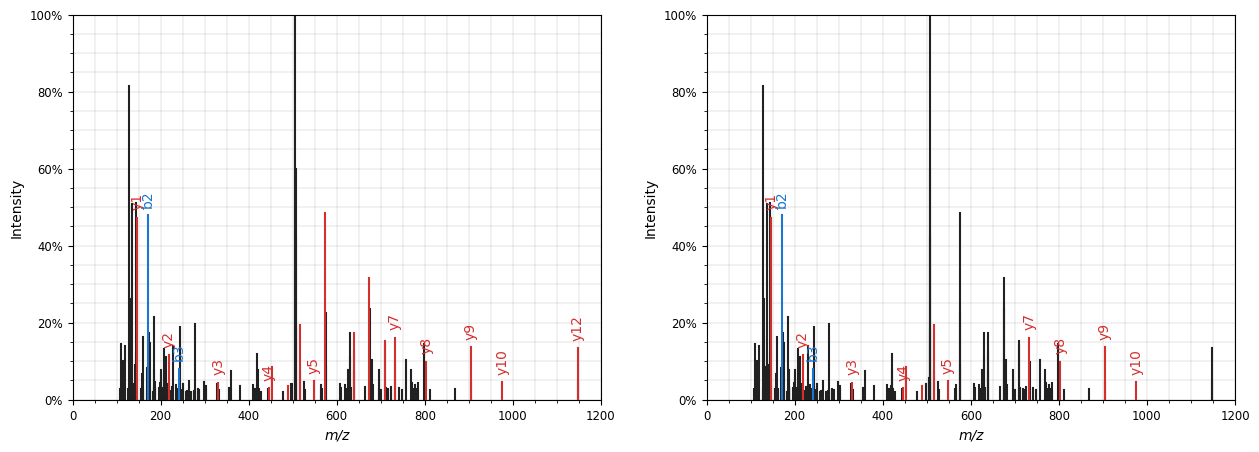

In [116]:
spec_casa = plot_spectrum(
    mgf_path=mgf_path,
    spectrum_id="controllerType=0 controllerNumber=1 scan=15412",
    peptide="VAAEN[UNIMOD:7]GATAGKTDLAK/3",
    plot=False
)
spec_sage = plot_spectrum(
    mgf_path=mgf_path,
    spectrum_id="controllerType=0 controllerNumber=1 scan=15412",
    peptide="VAAENGATAGKTDLAK/3",
    plot=False
)

fig, ax = plt.subplots(1,2, figsize=(15,5))

sup.spectrum(spec_casa, ax=ax[0])
sup.spectrum(spec_sage, ax=ax[1])

In [106]:
from ms2pip.core import predict_single

casa_pred = predict_single(peptidoform="KEAKPGELQKK/2", model="HCD2021").as_spectra()[0].to_spectrum_utils()
sage_pred = predict_single(peptidoform="KEAKPAVEQKK/2", model="HCD2021").as_spectra()[0].to_spectrum_utils()

<Axes: xlabel='m/z', ylabel='Intensity'>

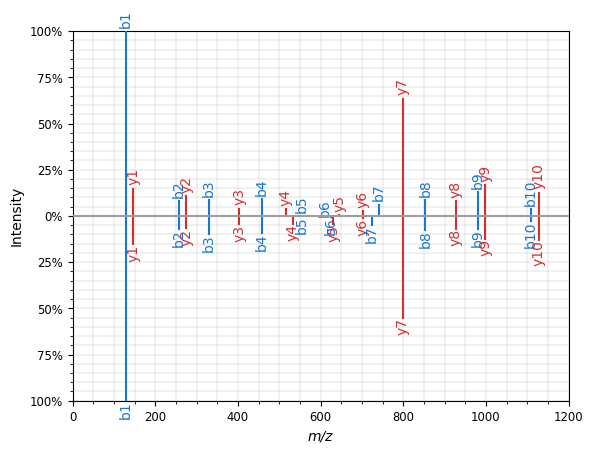

In [108]:
sup.mirror(casa_pred, sage_pred)

In [81]:
df_filtered.loc[
    df_filtered.spectrum_id=="controllerType=0 controllerNumber=1 scan=1145",
    ["source", "hyperscore_diff", "match_db", "peptide", "proforma"]
]

,source,hyperscore_diff,match_db,peptide,proforma
232,Casanovo4.2.0,0.000000,False,KEAKPGELQKK,KEAKPGELQKK/2
81062,InstaNovo,0.000000,False,KEAKPGELQKK,KEAKPGELQKK/2
161839,PepNet,-7.905860,False,EKAKPVAVEKK,EKAKPVAVEKK/2
244904,ContraNovo,0.000000,False,KEAKPDLAQKK,KEAKPDLAQKK/2
285542,NovoB,-9.561822,False,MPTKPLNTVKK,MPTKPLNTVKK/2
364190,Novor,-9.561822,False,EEKAPASRLKK,EEKAPASRLKK/2
444998,PepNovo+,-11.291686,False,PLLDSQK,PLLDSQK/2
547984,sage,0.000000,True,KEAKPAVEQKK,KEAKPAVEQKK/2


In [138]:
psmlist["qvalue"]

array([None, None, None, ..., 0.25964093, 0.25964093, 0.25964093],
      dtype=object)

In [ ]:
psmlist.

In [139]:
psmlist["qvalue"] = [1 if x is None else x for x in psmlist["qvalue"]]

In [146]:
spectrum_ids_to_keep = psmlist[
    (psmlist["source"]=="sage") &
    (psmlist["qvalue"]<.01)
]["spectrum_id"]

spec_list = []
for spec in tqdm(psmlist["spectrum_id"]):
    if spec in spectrum_ids_to_keep:
        spec_list.append(spec)

100%|██████████| 588585/588585 [07:12<00:00, 1359.40it/s]


In [20]:
def evaluate_prediction_isobaricity(
        row, ground_truth_peptide, ground_truth_hyperscore
):
    try:
        sequence_match = ground_truth_peptide[
            row["spectrum_id"]
        ] == row["peptide"]
        if sequence_match:
            return "Match"
        
        ref_hyperscore = ground_truth_hyperscore[row["spectrum_id"]]
        if row["hyperscore"] == ref_hyperscore:
            return "Isobaric"
        
        elif row["hyperscore"] > ref_hyperscore:
            return "Better"

        elif row["hyperscore"] < ref_hyperscore:
            return "Worse"

        else:
            return "Error?"

    except:
        return "Unpredicted"

In [35]:
ground_truth_peptide = df_filtered.loc[df_filtered.source=="sage", ["spectrum_id", "peptide"]].set_index("spectrum_id").to_dict()["peptide"]
ground_truth_hyperscore = df_filtered.loc[df_filtered.source=="sage", ["spectrum_id", "hyperscore"]].set_index("spectrum_id").to_dict()["hyperscore"]

In [119]:
df_filtered["match_type"] = df_filtered.progress_apply(
    lambda x: evaluate_prediction_isobaricity(
        x, 
        ground_truth_peptide=ground_truth_peptide, 
        ground_truth_hyperscore=ground_truth_hyperscore
    ), axis=1
)

100%|██████████| 295140/295140 [00:01<00:00, 182448.04it/s]


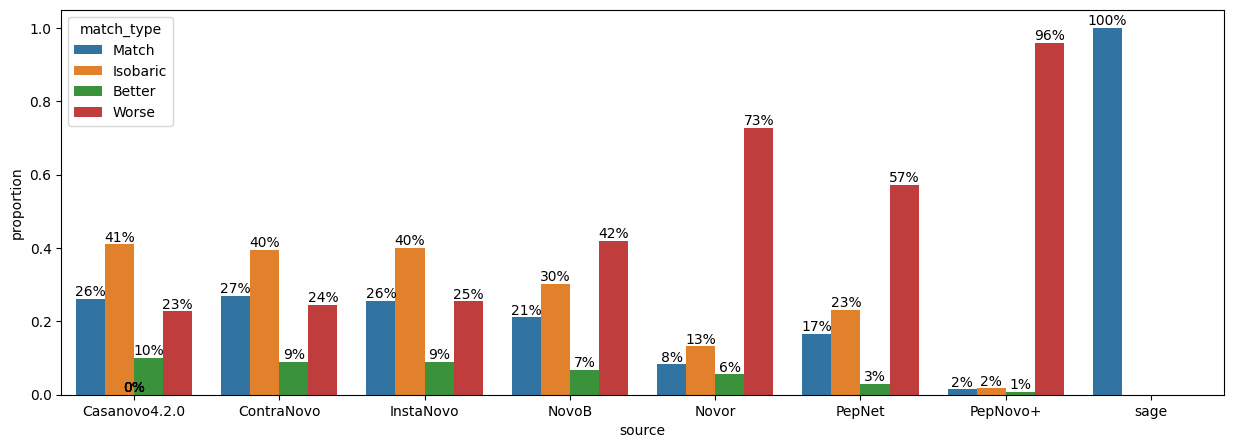

In [130]:
plt.figure(figsize=(15,5))
ax= sns.barplot(
    df_filtered.groupby("source").match_type.value_counts(normalize=True).reset_index(),
    x="source",
    hue="match_type",
    y="proportion",
    hue_order=["Match", "Isobaric", "Better", "Worse"]
)

# Annotate the bars
for p in ax.patches:
    height = p.get_height()  # Get the height of each bar
    ax.annotate(f'{height:.0%}',  # Format as percentage with two decimal places
                (p.get_x() + p.get_width() / 2., height),  # Position the text in the center of the bar
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),  # Slightly offset the text above the bar
                textcoords='offset points')
plt.show()

In [134]:
df_filtered.source.value_counts()/df_filtered.source.value_counts().max()

source
PepNet           1.000000
sage             1.000000
InstaNovo        0.999230
Novor            0.998858
Casanovo4.2.0    0.998609
NovoB            0.988329
PepNovo+         0.840030
ContraNovo       0.503973
Name: count, dtype: float64

Loads of isobaric sequences!

In [163]:
isobarics = df_filtered[df_filtered["match_type"]=="Isobaric"].groupby("spectrum_id").apply(lambda x: x[["peptide", "source"]].set_index("source").to_dict()["peptide"])
isobarics = isobarics.reset_index().rename(columns={0: "dn_dict"})
isobarics.head(3)

,spectrum_id,dn_dict
0,controllerType=0 controllerNumber=1 scan=10004,"{'Casanovo4.2.0': 'TTCPCCPASQR', 'InstaNovo': ..."
1,controllerType=0 controllerNumber=1 scan=10005,"{'Casanovo4.2.0': 'KPETLNYR', 'InstaNovo': 'KP..."
2,controllerType=0 controllerNumber=1 scan=10010,{'Novor': 'TSAPALQK'}


In [164]:
isobarics["n"] = isobarics.dn_dict.apply(len)

In [166]:
isobarics.n.value_counts()

n
1    4477
4    3810
5    3758
2    3724
3    3409
6    1769
7     166
Name: count, dtype: int64

In [177]:
df_filtered.loc[
    (df_filtered.spectrum_id=="controllerType=0 controllerNumber=1 scan=10004"),
    ["proforma", "source", "spectralis_score", "hyperscore"]
]

,proforma,source,spectralis_score,hyperscore
8094,TTC[UNIMOD:4]PC[UNIMOD:4]C[UNIMOD:4]PASQR/2,Casanovo4.2.0,-1.432808,21.994691
88835,TTC[UNIMOD:4]PC[UNIMOD:4]C[UNIMOD:4]PSQAR/2,InstaNovo,-1.451577,21.994691
169782,TTC[UNIMOD:4]PC[UNIMOD:4]C[UNIMOD:4]PQGKR/2,PepNet,-2.106584,8.846564
293268,LSC[UNIMOD:4]PC[UNIMOD:4]SDDLDR/2,NovoB,-1.939287,9.924220
371971,TTC[UNIMOD:4]PC[UNIMOD:4]C[UNIMOD:4]HHHK/2,Novor,-1.607493,13.783564
450460,LPLVWGV/2,PepNovo+,-2.007730,0.000000
532565,TTC[UNIMOD:4]PC[UNIMOD:4]C[UNIMOD:4]GGPATR/2,sage,-1.529562,21.994691


In [167]:
isobarics.loc[0, "dn_dict"]

{'Casanovo4.2.0': 'TTCPCCPASQR', 'InstaNovo': 'TTCPCCPSQAR'}

---

In [36]:
df["match_type"] = df.progress_apply(
    lambda x: evaluate_prediction_isobaricity(
        x, 
        ground_truth_peptide=ground_truth_peptide, 
        ground_truth_hyperscore=ground_truth_hyperscore
    ), axis=1
)

100%|██████████| 588585/588585 [00:02<00:00, 253233.49it/s]


In [40]:
from denovo_utils.utils.pandas import collapse_casanovo_score

df["score"] = df.apply(collapse_casanovo_score, axis=1)

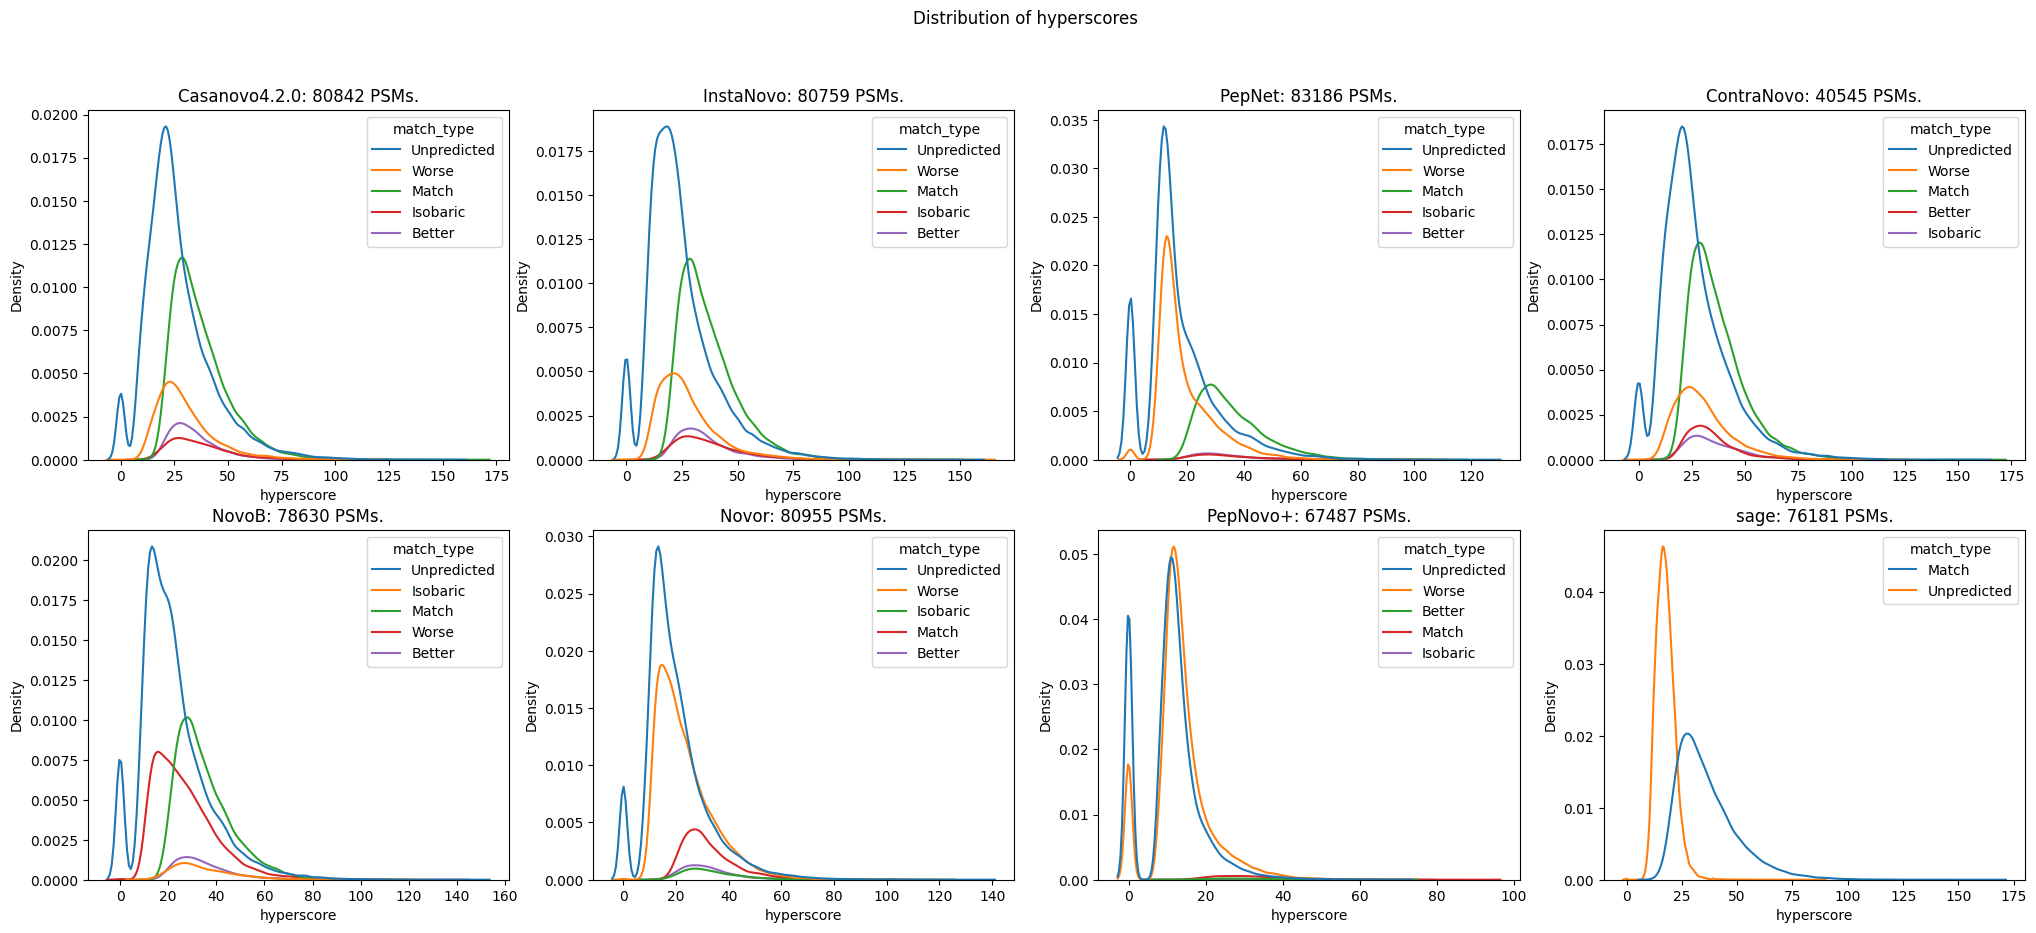

In [41]:
fig, ax = plt.subplots(2,4, figsize=(25,10))

x=0

fig.suptitle("Distribution of hyperscores")
for y, engine in enumerate(df.source.unique()):
    if y >= 4:
        x=1
        y-=4
    selection = df[
        df.source==engine
    ]
    sns.kdeplot(
        selection,
        x="hyperscore",
        hue="match_type",
        ax=ax[x][y]
    )
    ax[x][y].set_title(f"{engine}: {len(selection)} PSMs.")

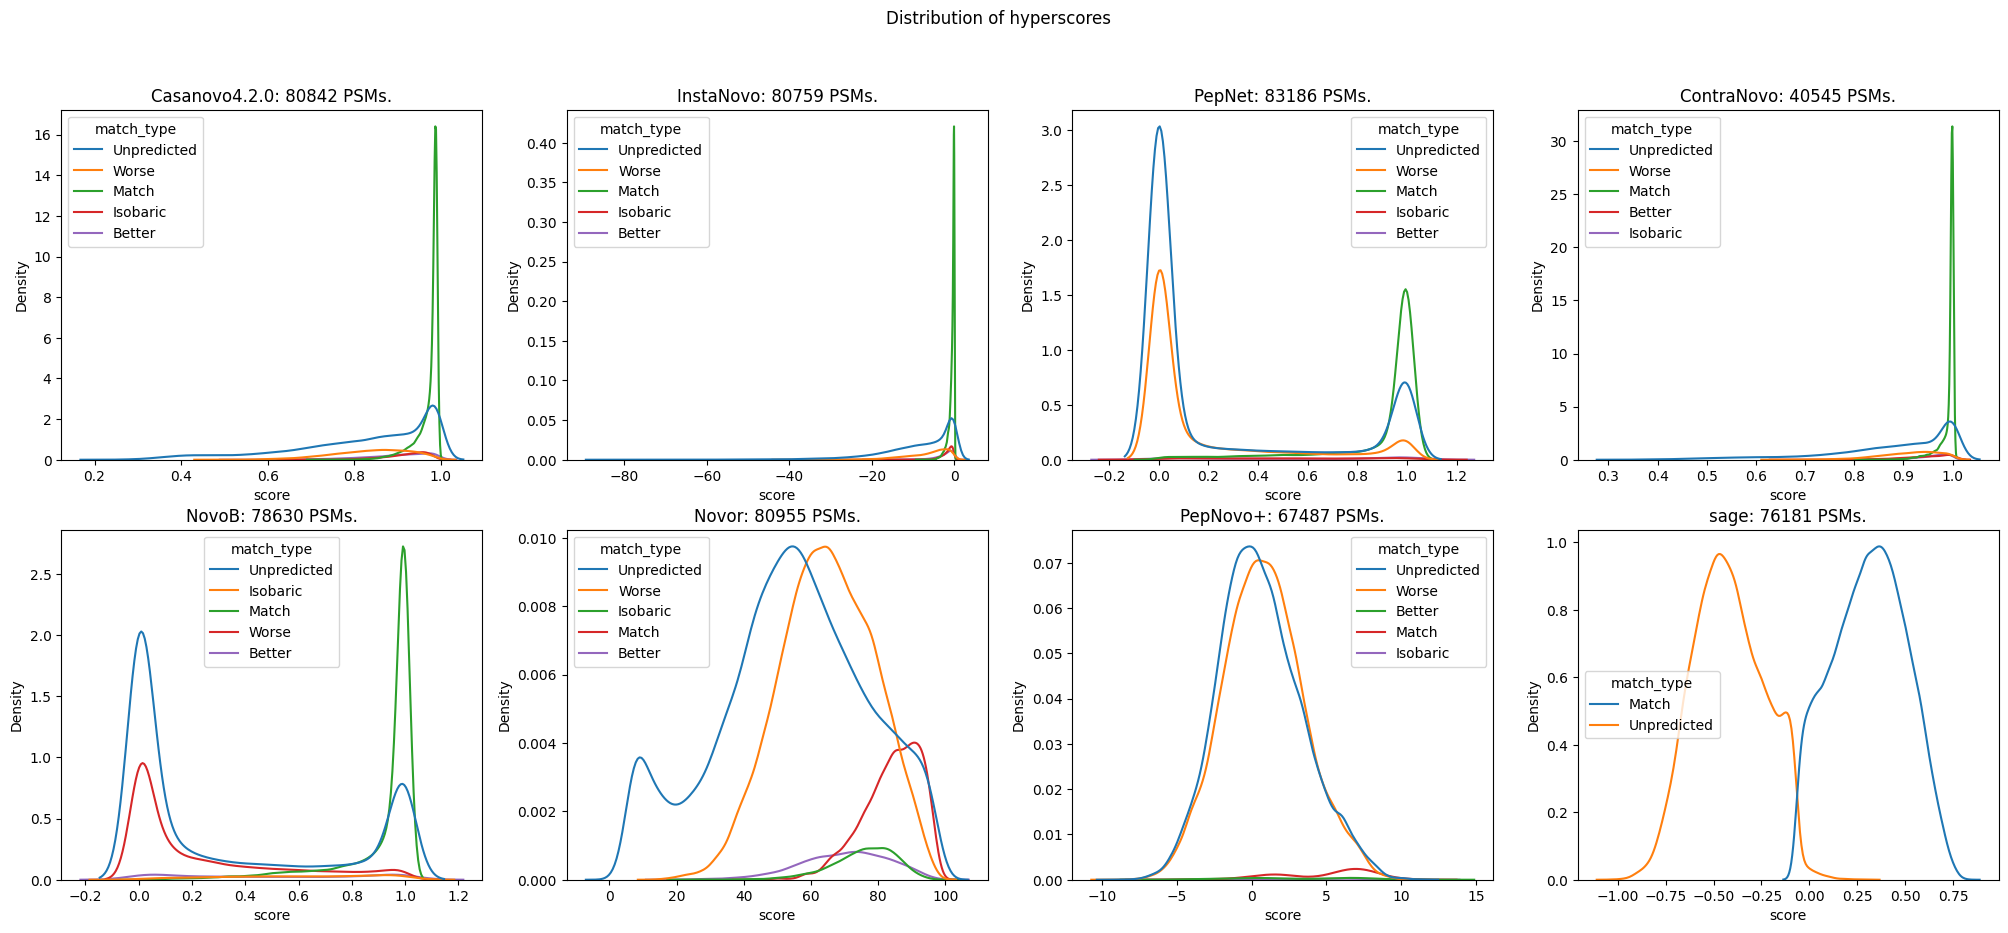

In [42]:
fig, ax = plt.subplots(2,4, figsize=(25,10))

x=0

fig.suptitle("Distribution of hyperscores")
for y, engine in enumerate(df.source.unique()):
    if y >= 4:
        x=1
        y-=4
    selection = df[
        df.source==engine
    ]
    sns.kdeplot(
        selection,
        x="score",
        hue="match_type",
        ax=ax[x][y]
    )
    ax[x][y].set_title(f"{engine}: {len(selection)} PSMs.")

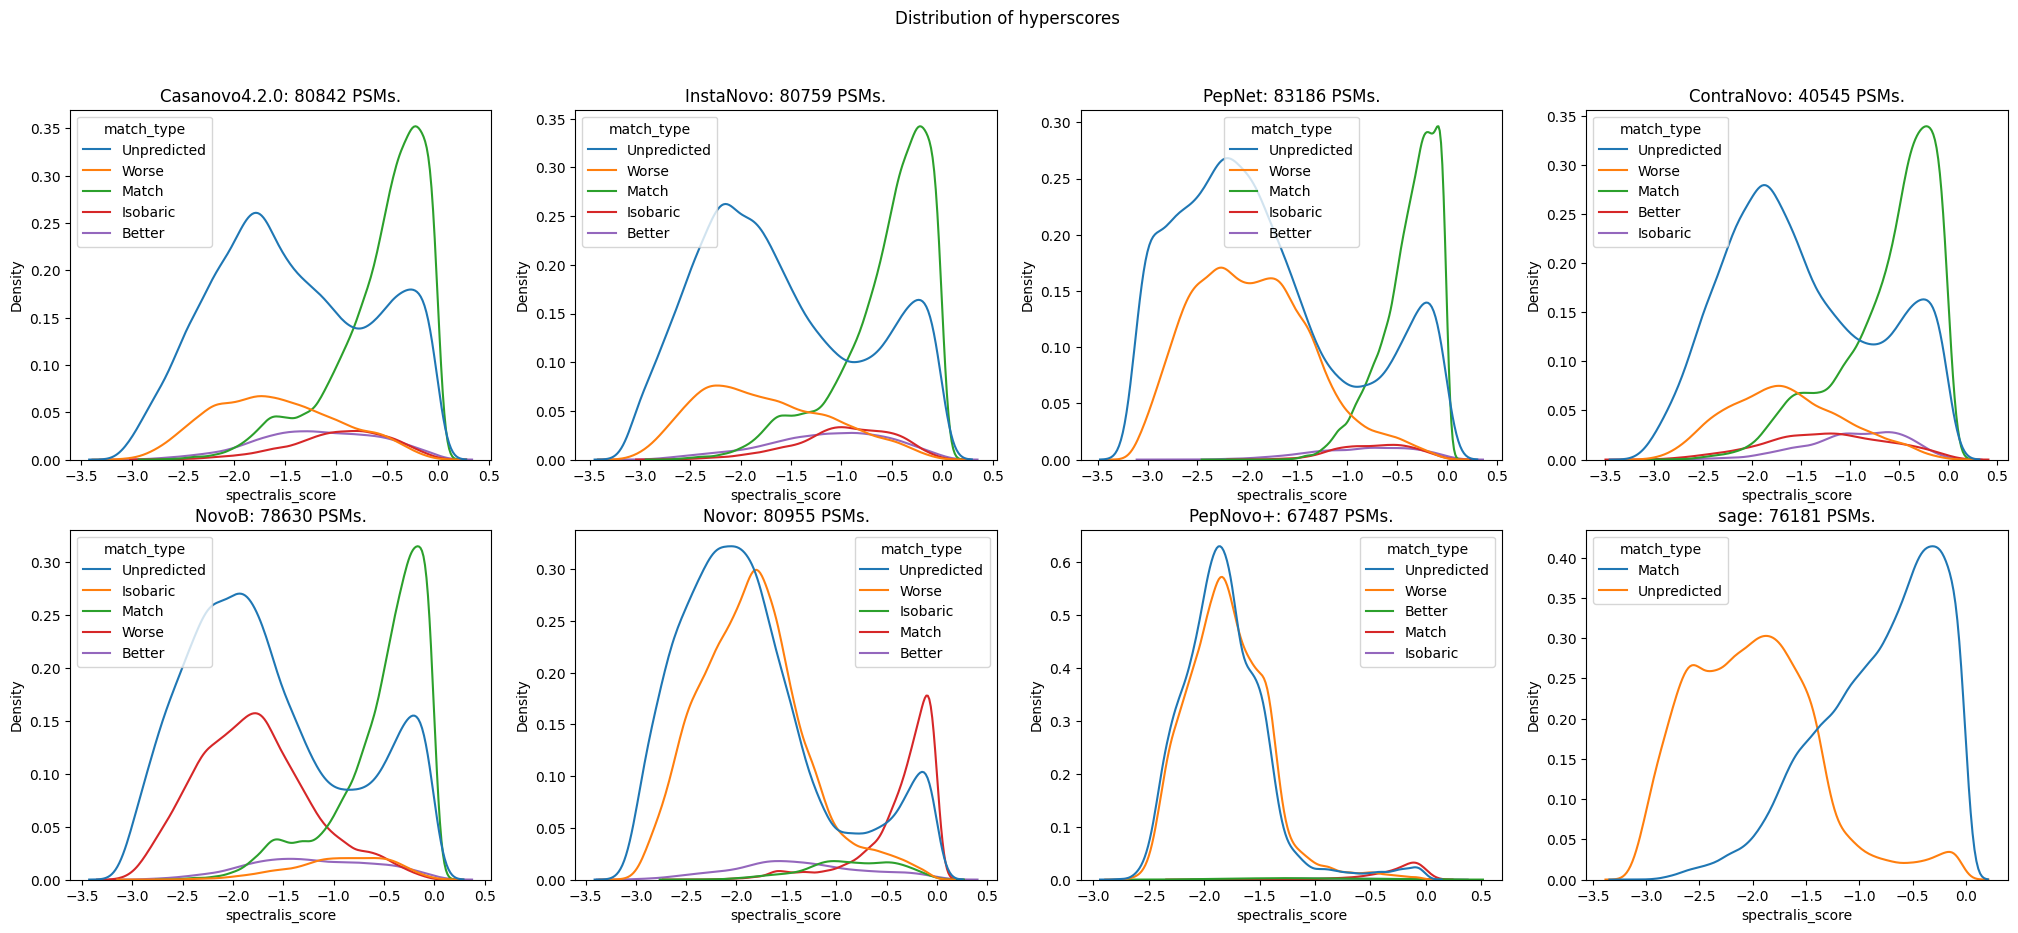

In [43]:
fig, ax = plt.subplots(2,4, figsize=(25,10))

x=0

fig.suptitle("Distribution of hyperscores")
for y, engine in enumerate(df.source.unique()):
    if y >= 4:
        x=1
        y-=4
    selection = df[
        df.source==engine
    ]
    sns.kdeplot(
        selection,
        x="spectralis_score",
        hue="match_type",
        ax=ax[x][y]
    )
    ax[x][y].set_title(f"{engine}: {len(selection)} PSMs.")